<a href="https://colab.research.google.com/github/marlongonzalez-dotcom/imagenes/blob/main/Copia_de_Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Procesamiento de imágenes de torres de transmisión**

Código realizado por: Julio Bracamonte, Marlon González y Laura Sofía Alarcón.

El siguiente notebook tiene como objetivos principales mostrar el procesamiento de imágenes tomadas por drones a torres de transmisión eléctrica y entrenar un modelo sencillo para detectar óxido en el soporte de los pararrayos de las mismas.

La librerías centrales para completar esta labor son: cv2, matplotlib.pyplot, numpy, os, sklearn, skimages  y zipfile.

## **Importar Librerías**

En este paso preliminar, se importan la mayoría de las librerías mencionadas para completar la tarea. El resto de librerías como sklearn y skimage se importarán más adelante cuando se llegue a la sección dedicada al entrenamiento del modelo para la detección de óxido.

In [ ]:
import zipfile
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## **Lectura de los datasets**

Para este paso, hay que asegurarse de tener las carpetas comprimidas subidas al Colab.

Cabe destacar que las carpetas comprimidas son una porción del total de datos contenidos en los datasets en los que se basa este trabajo. Para más información acerca de estos mismos, consultar los enlaces a continuación:

Torres de Transmisión:
https://doi.org/10.48550/arXiv.2311.02747

Detección de fallas:
https://doi.org/10.1080/01431161.2023.2283900

**Nota:** Dado que Google Colab no admite carpetas directamente, los datasets fueron subidos en forma de carpetas comprimidas. La librería 'zipfile' permite descomprimir dichas carpetas y almancenarlas temporalmente en el notebook.

In [ ]:
with zipfile.ZipFile("torres.zip", "r") as zip_ref:
    zip_ref.extractall("torres")

with zipfile.ZipFile("soporte_pararrayos.zip", "r") as zip_ref:
    zip_ref.extractall("soporte_pararrayos")

## **Recorrer cada imagen con 'os.walk'**

En el siguiente paso, se listará cada imagen contenida en las carpetas recién extraídas.

Las imágenes relacionadas a las torres en general se almacenarán en una carpeta de nombre 'rutas_torres'. Del mismo modo para las imágenes que muestren soportes de pararrayos.

In [ ]:
def lista_imagenes(carpeta):
    exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    rutas = []
    for root, dirs, files in os.walk(carpeta):
        for f in files:
            if f.lower().endswith(exts):
                rutas.append(os.path.join(root, f))
    return sorted(rutas)

rutas_torres = lista_imagenes("torres")
rutas_soporte_pararrayos = lista_imagenes("soporte_pararrayos")

print("Imágenes torres:", len(rutas_torres))
print("Imágenes pararrayos:", len(rutas_soporte_pararrayos))

Imágenes torres: 25
Imágenes pararrayos: 910


**Nota:** Existe una mayor cantidad de imágenes relacionadas con los pararrayos puesto que serán usadas para alcanzar el segundo objetivo de este notebook, entrenar un modelo para la detección de óxido. Mientras que las imágenes de las distintas torres, son usadas únicamente para mostrar visualmente la diferencia de una imagen procesada de otra sin procesar.

## **Lectura y preporocesamiento de imágenes**

A continuación, se definen dos funciones 'lectura_y_tam' que se encarga de leer una imagen y modificar su tamaño. Y otra de nombre 'prepocesar' que utiliza la función 'cv.Cvtcolor' para pasar la imagen de BGR a escalas de grises; asismiso, emplea la función 'GaussianBlur' de la misma librería Opencv (nombrada cv en el código) para eliminar cualquier ruido que contenga la imagen; finalmente, usa la función Canny, también de opencv, para resaltar el contorno de las torres.

In [ ]:
def lectura_y_tam(path, size=(512,512)):
    img = cv.imread(path)
    if img is None:
        raise ValueError(f"Imagen no leída: {path}")
    img = cv.resize(img, size, interpolation=cv.INTER_AREA)
    return img

def preprocesar(img, blur_kernel=(5,5), canny_thresh=(30,125)):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, blur_kernel, 0)
    edges = cv.Canny(blur, canny_thresh[0], canny_thresh[1])
    return gray, blur, edges


**Nota:** para cada imagen ingresada en la entrada de la función 'lectura_y_tam' se reajusta a un tamaño estándar de 512x512. Similarmente, en la función 'preprocesar' se introduce el kernel a un tamaño de 5x5, es importante que estos valores sean impares porque para realizar el suavizado Gaussiano se toma siempre el píxel que se encuentre en el centro, con una matriz de orden 2x2 o 4x4 (pares) no se podría ejecutar correctamente la función 'GaussianBlur'.

Del mismo modo, se definen los parámetros 'canny_tresh' que son los que determinan cuál píxel evaluado se encuentra en un borde y cuál no.

## **Visualizar ejemplos**

En esta sección se define la función que permite observar las diferencias entre una imagen sin filtrar, cuando se le aplica el cambio de color a escala de grises, cuando se suaviza y cuando se delimitan los bordes de las torres.

Ejemplo de torre:


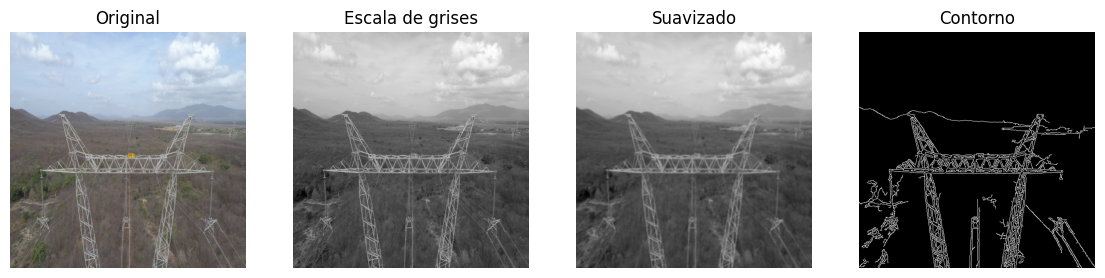

Ejemplo de pararrayos:


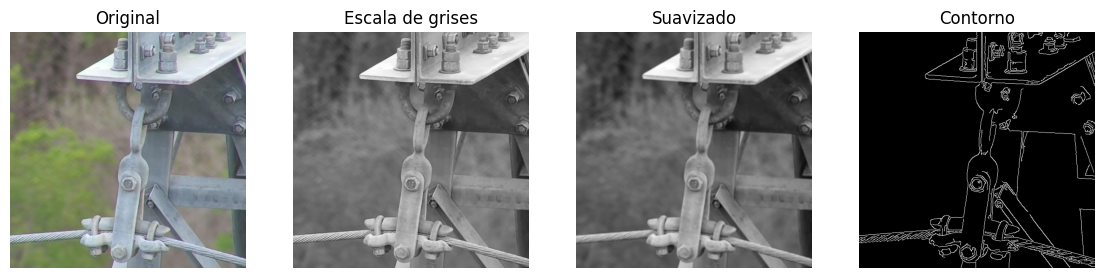

In [ ]:
def visualizar_ejemplo(ruta):
    img = lectura_y_tam(ruta)
    gray, blur, edges = preprocesar(img)

    plt.figure(figsize=(14,5))
    plt.subplot(1,4,1)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.imshow(gray, cmap='gray')
    plt.title("Escala de grises")
    plt.axis('off')

    plt.subplot(1,4,3)
    plt.imshow(blur, cmap='gray')
    plt.title("Suavizado")
    plt.axis('off')

    plt.subplot(1,4,4)
    plt.imshow(edges, cmap='gray')
    plt.title("Contorno")
    plt.axis('off')
    plt.show()

# Muestra un ejemplo de cada lista si existen
if len(rutas_torres) > 0:
    print("Ejemplo de torre:")
    visualizar_ejemplo(rutas_torres[0])
if len(rutas_soporte_pararrayos) > 0:
    print("Ejemplo de pararrayos:")
    visualizar_ejemplo(rutas_soporte_pararrayos[10])


## **Entrenamiento y evaluación del modelo**

Esta es la meta final del notebook, aquí se entrenará el modelo para identificar si la pieza de soporte del pararrayos se encuentra en buen estado o está oxidada. Para completar esta labor se necesita de diversas funciones de la librería 'Scikit-learn' cuyo enfoque es el aprendizaje automático (machine-learning).

A lo largo de esta última sección del código se presentarán las funciones a importar de 'sklearn' y 'skimages', se explicarán los pasos más relevantes al momento de entrenar y evaluar al modelo junto con las métricas y las predicciones. Finalmente se compartirán los resultados obtenidos.

### **Funciones a importar de 'skimages y 'sklearn'**

En este paso, se importan las funciones necesarias para completar la misión.

In [ ]:
from skimage.feature import hog, local_binary_pattern
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### **Extracción de rasgos**

Aunque funciones existen funciones como 'calcHist' que permite encontrar la distribución de pixeles para las diferentes tonalidades en una imagen; y que esta función se puede complementar con el conteo de bordes gracias a 'cv.Canny'.

Se deben tener en cuenta más aspectos como la forma, la textura y la granularidad para determinar con exactitud cuál imagen representa una pieza con óxido y cuál muestra una pieza en buen estado. Para ello, se utilizarán funciones como 'hog' y 'local_bilateral_pattern', ambas provenientes de la librería skimages.

El complemento de ambas funciones, hecho en la concatenación de np.hstack, permite tener una base sólida para determinar si la pieza evaluada está en buen estado o se encuentra oxidada.

In [ ]:
def extraer_rasgos(img_path):
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.resize(img, (256, 256))   # tamaño estándar

    # ---- HOG ----
    hog_features = hog(
        img,
        orientations=9,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False
    )

    # ---- LBP ----
    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 59), density=True)

    # Concatenar rasgos
    return np.hstack([hog_features, lbp_hist])

La función 'hog' Histogram of Gradient Orientation calcula la dirección y la magnitud del gradiente de cada píxel en la imagen, esto es, en qué dirección y con qué magnitud se presenta el mayor cambio de intensidad en cada píxel de la imagen. ¿Cómo lo hace?, de una manera muy ordenada, por este motivo fue que lo escogimos para el trabajo. En primer lugar calcula el gradiente para pixel. Luego divide la imagen en 'celdas', pequeñas regiones de espacio, en las cuales se halla la distribución de la dirección los gradientes de cada píxel (vertical, horizontal, etc.). Posteriormente, estas distribuciones obtenidas 'histogramas', se agrupan en bloques, los cuales son normalizados para evitar ruido y arrojar bordes por cambios en la iluminación. Finalmente concatena cada valor obtenido en un vector que representa las formas en la imagen.



Por otro lado, la función 'local_binary_pattern' compara un pixel en específico con respecto a sus 'vecinos', dependiendo de la intensidad de los píxeles respecto al centro seleccionado, se asigna un valor binario. Este valor binario de cada vecino se concatena y son ello, se crea un 'histograma' que refleja la frecuencia de cada patrón binario construido en el paso anterior. Este 'histograma', sirve como el vector final para reflejar la textura que posee la imagen.

### **Preparación de los datasets para el entrenamiento modelo**

Luego de haber definido las funciones que extraerán las características a evaluar en cada imagen, se organizan los datasets que serán usados en el entrenamiento del modelo de detección de piezas oxidadas.

In [ ]:
rutas_buen_estado = lista_imagenes("/content/soporte_pararrayos/good")
rutas_oxidados = lista_imagenes("/content/soporte_pararrayos/rust")

X = []
y = []

for p in rutas_buen_estado: X.append(extraer_rasgos(p)); y.append(0)
for p in rutas_oxidados: X.append(extraer_rasgos(p)); y.append(1)
X = np.array(X); y = np.array(y)


El uso de la función 'extraer_rasgos' produce un vector de características que se almacena en la lista X. Mientras que la lista 'y' almacena etiquetas binarias donde 0 representa 'goog', buen estado; y 1 se ascoia a 'rust', oxidada.

Finalmente, ambas listas se convierten en arreglos de numpy para que la librería de sklearn no tenga problemas con los datos.

### **Selección del número de folds y creación de las listas para las métricas**

En este paso previo al entrenamiento y validación se divide el dataset de 'soporte_pararrayos' en 5 partes más pequeñas, de nombre 'fold'. Esto se hace mediante la función 'StratifiedKFold', la cual se encarga de mantener la proporción de imágenes de las piezas en buen estado con respecto a la cantidad de piezas oxidadas. Esta función fue seleccionada debido a que hay una mayor cantidad de imágenes de piezas en buen estado que oxidadas.

In [ ]:
# Número de folds
k = 5

# Configuramos K-Fold estratificado para mantener proporciones por clase
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

resultados = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
}
print("Shape X:", X.shape)

Shape X: (910, 8158)


### **Ciclo de entrenamiento/evaluación**

En esta de sección se realiza el ciclo de entrenamiento y evaluación del modelo. El método implementado recibe el nombre de 'Stratified K-Fold Cross Validation', aunque suene complicado, el funcionamiento es el siguiente: el paso anterior dividía el dataset 'soporte_pararrayos' en 5 partes (folds) que mantengan la proporción original de imágenes en buen estado e imágenes oxidadas. Durante el ciclo de entramiento, se emplean 4 de los 5 folds para entrenar al modelo. El quinto fold se usa como evaluación. Este proceso se repite 5 veces, es decir, hasta que todos los folds sean usados en la evaluación del modelo.


In [ ]:
#Ciclo de entrenamiento con K-fold
i = 1
for train_idx, test_idx in kf.split(X, y):
    print(f"\n===== FOLD {i} =====")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = make_pipeline(StandardScaler(), SVC(kernel="linear", probability=True))
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    resultados["accuracy"].append(acc)
    resultados["precision"].append(prec)
    resultados["recall"].append(rec)
    resultados["f1"].append(f1)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")

    i += 1


===== FOLD 1 =====
Accuracy: 0.9835
Precision: 0.9701
Recall: 0.9848
F1-score: 0.9774

===== FOLD 2 =====
Accuracy: 0.9505
Precision: 0.9524
Recall: 0.9091
F1-score: 0.9302

===== FOLD 3 =====
Accuracy: 0.9780
Precision: 0.9559
Recall: 0.9848
F1-score: 0.9701

===== FOLD 4 =====
Accuracy: 0.9560
Precision: 0.9265
Recall: 0.9545
F1-score: 0.9403

===== FOLD 5 =====
Accuracy: 0.9615
Precision: 0.9403
Recall: 0.9545
F1-score: 0.9474


Para cada fold recorrido se calculan 4 métricas de evaluación al modelo: Accuracy, Precision, Recall y F1-score. Todas las métricas, fueron calculadas por las funciones importadas de sklearn previamente.

Antes de explicar cada una es importante definir el concepto de matriz de confunsión. Debido a que el problema de detección de piezas oxidadas es de estilo binario (la pieza está oxidada o no lo está). Existen cuatro tipos de respuestas en una predicción: *True positive* (cuando el modelo acierta en la predicción de una pieza oxidada), *False Positive* (Cuando el modelo asigna como 'oxidada' a una pieza en buen estado), *True Negative* (Cuando la predicción de una pieza en buen estado es correcta) y *False Negative* (Cuando una pieza oxidada aparece como pieza en buen estado en la predicción).

Accuracy mide la cantidad de predicciones acertadas frente al total de muestras tomadas, la salida de esta función es un flotante, en caso de resultar 1 el modelo habría acertado todas las predicciones. Sin embargo, al usarse en datasets poco balanceados, no es una métrica tan representativa como lo sería en un dataset con igual cantidad de muestras en ambas clasificaciones (400 piezas en buen estado y 400 piezas oxidadas por ejemplo).

Por otro lado, Precision mide el total de aciertos *True Positive* frente al total de predicciones positivas. En otras palabras, cuántas de las piezas calificadas como oxidadas realmente estaban oxidadas en relación del total de piezas categorizadas como oxidadas.

De un modo similar, Recall calcula cuántos de los datos que debieron ser asignados como positivos (oxidados) lo fueron. A diferencia de Precision, esta función toma en cuenta los *False Negatives* en lugar de *False positives*.

Finalmente, la función F1_Score implementa tanto los resultados obtenidos en Precision como Recall. Así como las funciones anteriores, los valores resultantes de F1_score oscilan entre 1 y 0, siendo 1 el mejor resultado posible. Para datasets no tan balanceados (como el implementado en este notebook), F1_score proporciona datos más representativos que accuracy.

### **Resultados Finales**

En esta breve sección se toma el promedio de cada una de las métricas en los distintos folders. De este modo se termina de evaluar el desempeño del modelo. Esto se consigue sencillamente con la función 'mean' de numpy.

In [ ]:
print("\n===== MÉTRICAS PROMEDIO =====")
print("Accuracy promedio:", np.mean(resultados["accuracy"]))
print("Precision promedio:", np.mean(resultados["precision"]))
print("Recall promedio:", np.mean(resultados["recall"]))
print("F1-score promedio:", np.mean(resultados["f1"]))


===== MÉTRICAS PROMEDIO =====
Accuracy promedio: 0.9659340659340658
Precision promedio: 0.9490363309502905
Recall promedio: 0.9575757575757576
F1-score promedio: 0.9530984698817505


### **Clasificación por índice de la imagen**

En este último paso, se define la función 'clasificar_por_indice' cuyo objetivo es probar el modelo para una imagen dada. Para ello se crea una carpeta de nombre 'rutas_total' la cual, almacena todas las imagenes contenidas 'soporte_pararrayos'. De este modo, el usuario no tendría que introducir los extensos nombres de las imágenes que desee revisar, sino que eligiría una posición dentro de la carpeta 'rutas_total'.

Además, permite al usuario visualizar la imagen original junto con el diagnóstico que lanza el modelo.

In [ ]:
rutas_total = rutas_buen_estado + rutas_oxidados

In [ ]:
def clasificar_por_indice(idx):
    idx -= 1
    if idx < 0 or idx >= len(rutas_total):
        print("Índice fuera de rango.")
        return

    ruta = rutas_total[idx]
    rasgos = extraer_rasgos(ruta).reshape(1, -1)
    pred = model.predict(rasgos)[0]

    etiqueta = "OXIDADO" if pred == 1 else "BUEN ESTADO"

    img = cv.imread(ruta)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.title(f"Predicción: {etiqueta}")
    plt.axis("off")
    plt.show()

    print("Ruta:", ruta)
    print("Predicción:", etiqueta)


### **Espacio de pruebas**

En esta reducida sección, el usuario puede comprobar los resultados que arroja el modelo de una manera visual.

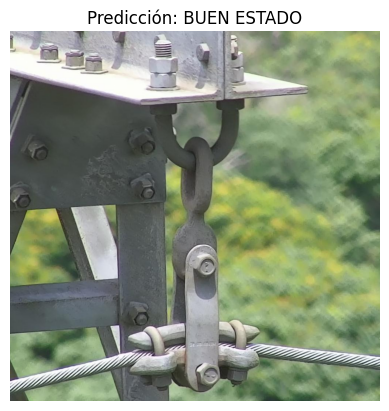

Ruta: /content/soporte_pararrayos/good/Fotos 08-12-2020_DJI_0663_suspensao_para_raio_118.jpg
Predicción: BUEN ESTADO


In [ ]:
clasificar_por_indice(600)

## **Conculsiones**

El código cumplió exitosamente con los dos objetivos planteados al inicio: mostrar los cambios visuales que recibe una imagen al momento de ser procesada y entrenar a un modelo para dectectar soportes de pararrayos oxidados.

A lo largo del notebook se pudo notar una presencia fundamental de la libreria OpenCV, tanto en el procesamiento inicial para el ejemplo inicial como en el entrenamiento y evaluación del modelo. Se puede afirmar que la libreria de OpenCV constituyó la base del notebook.

Adicionalmente, las métricas establecidas durante la evaluación del modelo aportaron una mayor confianza en el desempeño que realizó.

Por último, se consiguió definir una función que facilitara al usuario revisar manualmente cualquier imagen dentro del dataset con tan sólo ingresar el índice, esto es, en lugar de introducir el extenso nombre de una imagen, puede visualizar la predicción del código con un número entre 1 y 910 (el total de imágenes en el datset).